In [1]:
import pandas as pd
import numpy as np
import yaml
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor, Pool, EFeaturesSelectionAlgorithm
from collections import Counter
import optuna
import warnings
import pickle
warnings.filterwarnings("ignore")

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Функция для расчета WAPE (Weighted Absolute Percentage Error)
def wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

In [4]:
df = pd.read_csv('для модели v6.csv', parse_dates=['report_date'])

In [5]:
target_ = 'target_area'

In [49]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [7]:
def split_train_oot(data):
    # Находим самую позднюю дату в данных
    latest_date = data['report_date'].max()

    # Вычисляем дату, которая была три месяца назад от самой поздней даты
    three_months_ago = latest_date - pd.DateOffset(months=3)

    # Отбираем строки, где report_date попадает в последние три месяца
    data.loc[data['report_date'] >= three_months_ago, 'split_type'] = 'oot'

    # Теперь заполним NaN значения в столбце 'split_type' значением 'train'
    data.loc[data['split_type'].isna(), 'split_type'] = 'train'
    return data

In [8]:
# Функция для расчета всех метрик
def calculate_metrics(y_true, y_pred, dataset_name):
    return {
        'dataset': dataset_name,
        'MAE': mean_absolute_error(y_true, y_pred),
        'MSE': mean_squared_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred),
        'WAPE': wape(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'mean_target': y_true.mean(),
        'mean_pred': y_pred.mean(),
        'n_samples': len(y_true)
    }

In [9]:
def shap_gr(name_model, values):# Инициализация SHAP
    explainer = shap.TreeExplainer(name_model)
    shap_values = explainer.shap_values(values)

    # Создаем фигуру с регулируемым местом для шкалы
    plt.figure(figsize=(16, 8))

    ax1 = plt.axes([0.1, 0.1, 0.7, 0.8])  
    shap.summary_plot(shap_values, values,
                    max_display=20,
                    plot_type="dot",
                    color=plt.get_cmap("coolwarm"),
                    show=False,
                    plot_size=None)

    # Настройки графика
    ax1.set_title("Важность признаков по SHAP значениям", fontsize=14, pad=20)
    ax1.set_xlabel("Влияние на выход модели (SHAP value)", fontsize=12)
    ax1.set_ylabel("Признаки", fontsize=12)
    ax1.tick_params(labelsize=10)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    plt.show()

In [50]:
cat = split_train_oot(cat)

# Модель

# Тест 1

In [51]:
drop_cols = [
    'split_type', 
    'smt_building_addressid', 
    'sales__g_building__smt_projected_total_area__sum__1M', 
    'cost_net__g_building__sale_cost__sum__1M', 
    'report_date',
    'target_cost',
      target_
]

In [54]:
# Разделяем данные
train_data = cat[cat['split_type'] == 'train']
test_data = cat[cat['split_type'] == 'oot']

# Подготовка признаков
X_train = train_data.drop(columns=drop_cols)
y_train = train_data[target_]

X_test = test_data.drop(columns=drop_cols)
y_test = test_data[target_]

# Инициализация и обучение модели
model = CatBoostRegressor(
    iterations=2000,
    depth=4,
    learning_rate=0.2,
    loss_function='MAE',
    l2_leaf_reg=3,
    random_strength=1,
    early_stopping_rounds=100,
    verbose=0
)
model.fit(X_train, y_train)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_base = metrics_df

In [55]:
metrics_df_base

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,92.859948,31818.687659,178.377935,0.314369,0.177855,0.892929,522.109088,497.796720,5961
1,test,219.564145,108664.918830,329.643624,1.402345,0.707110,0.070813,310.508982,427.640153,1139


# Отбор фич

In [21]:
cat = df.copy()
cat.shape
# оставляем с непропущенными таргетом
cat=cat[cat[target_].notnull()]
cat.shape[0]

7100

In [22]:
cat = split_train_oot(cat)

In [23]:
# Подготовка данных
cat['report_date'] = pd.to_datetime(cat['report_date'])
cat['year_month'] = cat['report_date'].dt.to_period('M').astype(str)

# Уникальные значения по времени в тренировочной выборке
train_df = cat[cat['split_type'] == 'train'].copy()

feature_columns = [col for col in cat.columns if col not in drop_cols]

# Список для сбора выбранных фич и метрик
features_across_splits = []
metrics_across_splits = []

# Инициализация TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

# Сортируем данные по дате для корректного разбиения
train_df = train_df.sort_values('report_date')

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_split = train_df.iloc[train_index]
    val_split = train_df.iloc[val_index]
    
    train_dates = train_split['report_date'].min(), train_split['report_date'].max()
    val_dates = val_split['report_date'].min(), val_split['report_date'].max()
    
    print(f"\n🔹 Сплит {fold}: train = {train_dates[0]} - {train_dates[1]}, val = {val_dates[0]} - {val_dates[1]}")
    
    # Создание Pool объектов
    train_pool = Pool(
        data=train_split[feature_columns],
        label=train_split[target_],
        cat_features=['year_month']
    )
    
    val_pool = Pool(
        data=val_split[feature_columns],
        label=val_split[target_],
        cat_features=['year_month']
    )

    # Инициализация модели
    model = CatBoostRegressor(
        iterations=1000,
        depth=4,
        learning_rate=0.01,
        loss_function='MAE',
        verbose=False,
        grow_policy='Lossguide'
    )
    # Обучение модели
    model.fit(train_pool, eval_set=val_pool)
    
    # Предсказания и метрики
    y_train_pred = model.predict(train_pool)
    y_val_pred = model.predict(val_pool)
    
    # Расчет метрик для train
    train_metrics = {
        'split': f'fold_{fold}_train',
        'start_date': train_dates[0],
        'end_date': train_dates[1],
        'n_samples': len(train_split),
        'mean_target': train_split[target_].mean(),
        'mean_pred': y_train_pred.mean(),
        'mae': mean_absolute_error(train_split[target_], y_train_pred),
        'rmse': np.sqrt(mean_squared_error(train_split[target_], y_train_pred)),
        'mape': mean_absolute_percentage_error(train_split[target_], y_train_pred),
        'wape': wape(train_split[target_], y_train_pred),
        'r2': r2_score(train_split[target_], y_train_pred)
    }
    
    # Расчет метрик для validation
    val_metrics = {
        'split': f'fold_{fold}_val',
        'start_date': val_dates[0],
        'end_date': val_dates[1],
        'n_samples': len(val_split),
        'mean_target': val_split[target_].mean(),
        'mean_pred': y_val_pred.mean(),
        'mae': mean_absolute_error(val_split[target_], y_val_pred),
        'rmse': np.sqrt(mean_squared_error(val_split[target_], y_val_pred)),
        'mape': mean_absolute_percentage_error(val_split[target_], y_val_pred),
        'wape': wape(val_split[target_], y_val_pred),
        'r2': r2_score(val_split[target_], y_val_pred)
    }
    
    metrics_across_splits.extend([train_metrics, val_metrics])
    
    # Отбор фичей
    selected_features = model.select_features(
        train_pool,
        eval_set=val_pool,
        features_for_select=feature_columns,
        num_features_to_select=100,
        steps=2,
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        train_final_model=False,
        verbose=False
    )
    
    selected_features_names = [feature_columns[i] for i in selected_features['selected_features']]
    print(f" Отобрано фичей: {len(selected_features_names)}")
    features_across_splits.extend(selected_features_names)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame(metrics_across_splits)

# Форматируем даты 
metrics_df['start_date'] = metrics_df['start_date'].dt.strftime('%Y-%m-%d')
metrics_df['end_date'] = metrics_df['end_date'].dt.strftime('%Y-%m-%d')

# Переупорядочиваем столбцы
cols_order = ['split', 'start_date', 'end_date', 'n_samples', 'mean_target', 'mean_pred',
              'mae', 'rmse', 'mape', 'wape','r2']
metrics_df_select_features = metrics_df[cols_order]

# Анализ фичей
feature_counts = Counter(features_across_splits)
final_features = [f for f, count in feature_counts.items() if count >= 2]

print("\n Итоговые устойчивые фичи (встречались >= 2 раз):")
print("Количество:", len(final_features))



🔹 Сплит 1: train = 2022-03-01 00:00:00 - 2022-09-01 00:00:00, val = 2022-09-01 00:00:00 - 2023-03-01 00:00:00
Step #1 out of 2

bestTest = 211.454401
bestIteration = 325

Shrink model to first 326 iterations.
Feature #785 eliminated
Feature #245 eliminated
Feature #659 eliminated
Feature #365 eliminated
Feature #857 eliminated
Feature #20 eliminated
Feature #360 eliminated
Feature #356 eliminated
Feature #746 eliminated
Feature #604 eliminated
Feature #115 eliminated
Feature #354 eliminated
Feature #891 eliminated
Feature #984 eliminated
Feature #988 eliminated
Feature #967 eliminated
Feature #600 eliminated
Feature #224 eliminated
Feature #914 eliminated
Feature #238 eliminated
Feature #581 eliminated
Feature #54 eliminated
Feature #930 eliminated
Feature #675 eliminated
Feature #269 eliminated
Feature #544 eliminated
Feature #331 eliminated
Feature #89 eliminated
Feature #876 eliminated
Feature #124 eliminated
Feature #28 eliminated
Feature #421 eliminated
Feature #1031 eliminated
F

In [24]:
metrics_df_select_features

,split,start_date,end_date,n_samples,mean_target,mean_pred,mae,rmse,mape,wape,r2
0,fold_1_train,2022-03-01,2022-09-01,996,588.572450,531.626846,151.455614,282.305296,0.443848,0.257327,0.779696
1,fold_1_val,2022-09-01,2023-03-01,993,469.433515,464.656474,210.336421,316.929998,0.883689,0.448064,0.531708
2,fold_2_train,2022-03-01,2023-03-01,1989,529.092831,482.905846,139.499382,248.466198,0.460729,0.263658,0.788420
3,fold_2_val,2023-03-01,2023-08-01,993,461.282759,428.308836,193.862046,300.409754,0.939047,0.420267,0.598215
4,fold_3_train,2022-03-01,2023-08-01,2982,506.512213,463.609014,145.238435,249.692173,0.514696,0.286742,0.769461
5,fold_3_val,2023-08-01,2023-12-01,993,640.243868,508.515787,243.628540,399.044363,0.732113,0.380525,0.647600
6,fold_4_train,2022-03-01,2023-12-01,3975,539.919895,448.669662,219.616170,387.059668,0.799654,0.406757,0.530523
7,fold_4_val,2023-12-01,2024-03-01,993,448.587966,506.768904,232.512550,349.632210,1.268669,0.518321,0.486552
8,fold_5_train,2022-03-01,2024-03-01,4968,521.664539,476.793986,158.742566,266.578788,0.556503,0.304300,0.766427
9,fold_5_val,2024-03-01,2024-06-01,993,524.333173,391.367646,221.612273,344.382851,0.607504,0.422655,0.546944


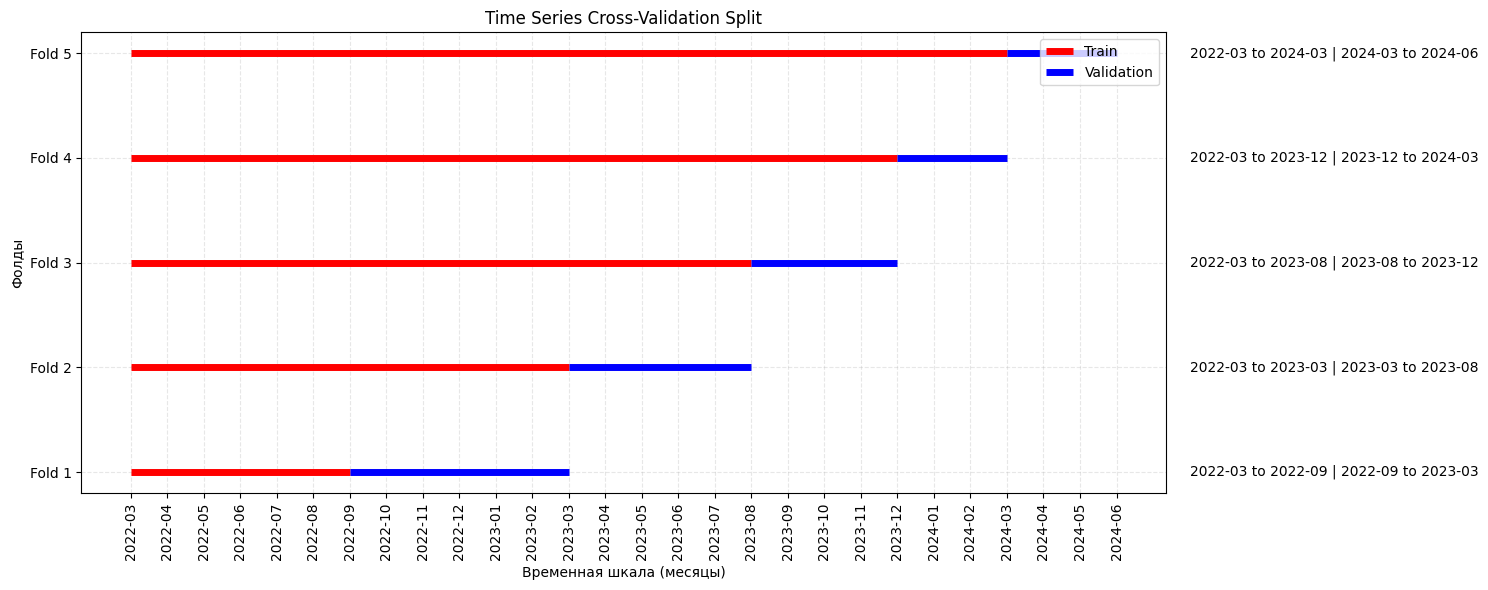

In [25]:
plt.figure(figsize=(15, 6))

# Получаем все уникальные даты
all_dates = np.sort(train_df['report_date'].unique())
date_labels = [str(date)[:7] for date in all_dates]  # Формат YYYY-MM

# Цвета для train/val
train_color = 'red'
val_color = 'blue'

for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    # Находим индексы дат
    train_idx = [np.where(all_dates == d)[0][0] for d in train_dates]
    val_idx = [np.where(all_dates == d)[0][0] for d in val_dates]
    
    # Рисуем линии
    plt.hlines(y=fold, xmin=min(train_idx), xmax=max(train_idx), 
              color=train_color, linewidth=5, label='Train' if fold == 1 else "")
    plt.hlines(y=fold, xmin=min(val_idx), xmax=max(val_idx), 
              color=val_color, linewidth=5, label='Validation' if fold == 1 else "")

# Настройка графика
plt.yticks(range(1, tscv.n_splits+1), [f'Fold {i}' for i in range(1, tscv.n_splits+1)])
plt.xticks(range(len(all_dates)), date_labels, rotation=90)
plt.title('Time Series Cross-Validation Split')
plt.xlabel('Временная шкала (месяцы)')
plt.ylabel('Фолды')
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper right')

# Добавим подписи дат для каждого фолда
for fold, (train_index, val_index) in enumerate(tscv.split(train_df), 1):
    train_dates = train_df.iloc[train_index]['report_date'].unique()
    val_dates = train_df.iloc[val_index]['report_date'].unique()
    
    plt.text(x=len(all_dates)+1, y=fold, 
             s=f"{train_dates[0].strftime('%Y-%m')} to {train_dates[-1].strftime('%Y-%m')} | {val_dates[0].strftime('%Y-%m')} to {val_dates[-1].strftime('%Y-%m')}",
             ha='left', va='center')

plt.tight_layout()
plt.show()

In [26]:
filtered_df = cat[list(set(cat.columns) & set(final_features))]
filtered_df.head(3)

,reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M,mortgages__g_building__smt_loan_period__min__3M,mortgages__g_building__required_amount__max__1M,area__g_building__smt_projected_total_area__free__count,sales__g_building__sale_cost__rooms_0__count__1M,sales__g_building__smt_projected_total_area__rooms_0__sum__3M,reservations__g_building__smt_projected_total_area__rooms_2__sum__6M,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,sales__g_building__sale_cost__min__1M,mortgages__g_building__maternal_capitalbit__count__3M,...,cbr__g_rd__usd_rub_rate__last2min__12M,area__g_building__smt_projected_total_area__rooms_2__count,crm_mortgages__g_rd__smt_approved_amount__avg__6M,balance__g_building__rooms_1__sum,expon_cost__g_building__pc_cost__min__1M,mortgages__g_building__open_application__count__12M,reservations__g_building__smt_projected_total_area__rooms_0__sum__12M,area__g_building__smt_projected_total_area__short_reservation__count,sales__g_building__sale_price__rooms_3plus__sum__3M,sales__g_building__smt_projected_total_area__sum__6M
11,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,...,1.355354,364.0,6918458.0,3255.4000,189968.0,0.0,NaN,0.0,NaN,0.0
12,177.6,180.0,219178.1,278.0,3.0,65.7,690.8,0.0,149089.60,8.0,...,1.460352,364.0,6931020.5,3061.4998,149109.0,34.0,65.7,4.0,29319736.0,893.0
13,744.3,60.0,149122.8,280.0,10.0,295.7,3461.2,0.0,109304.41,35.0,...,1.497203,364.0,7038550.0,2539.7998,141654.0,182.0,295.7,3.0,109707800.0,4418.8


In [27]:
# Разделение столбцов
numeric_cols =filtered_df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = filtered_df.select_dtypes(include=['object', 'category']).columns.tolist()

print("Числовые столбцы:", numeric_cols)
print("Категориальные столбцы:", categorical_cols)

Числовые столбцы: ['reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M', 'mortgages__g_building__smt_loan_period__min__3M', 'mortgages__g_building__required_amount__max__1M', 'area__g_building__smt_projected_total_area__free__count', 'sales__g_building__sale_cost__rooms_0__count__1M', 'sales__g_building__smt_projected_total_area__rooms_0__sum__3M', 'reservations__g_building__smt_projected_total_area__rooms_2__sum__6M', 'area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum', 'sales__g_building__sale_cost__min__1M', 'mortgages__g_building__maternal_capitalbit__count__3M', 'area__g_building__smt_projected_total_area__reservation_end_next_month__sum', 'price__g_building__rooms_2__sum__1M', 'area__g_building__smt_projected_total_area__rooms_3plus__count', 'area__g_building__smt_projected_total_area__long_reservation__count', 'expon_cost__g_building__pc_cost__avg__1_4M', 'balance__g_building__rooms_2__sum', 'floor__g_building__smt_floor__reserved__avg',

In [28]:

# Создаем словарь для YAML
data = {
    'numeric_columns': numeric_cols,
    'categorical_columns': categorical_cols,
    'id': ['smt_building_addressid'],
    'date' : ['report_date'],
    'target' : [target_]
}

# Записываем в YAML-файл
with open('features_model_area.yml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, sort_keys=False)

In [29]:
# загрузим фичи
with open('features_model_area.yml', 'r') as file:
    config = yaml.safe_load(file)

# 2. Извлечение списков столбцов
numeric_cols = config.get('numeric_columns', [])
target_cols = config.get('target', [])
id_col = config.get('id', [])
date_col = config.get('date', [])
all_config_columns = numeric_cols + categorical_cols+id_col+date_col+target_cols

In [30]:
filtered_df = cat[list(set(cat.columns) & set(all_config_columns))].reset_index(drop=True)
filtered_df.head(5)

,reservations__g_building__smt_projected_total_area__rooms_3plus__sum__3M,mortgages__g_building__smt_loan_period__min__3M,target_area,mortgages__g_building__required_amount__max__1M,area__g_building__smt_projected_total_area__free__count,sales__g_building__sale_cost__rooms_0__count__1M,sales__g_building__smt_projected_total_area__rooms_0__sum__3M,reservations__g_building__smt_projected_total_area__rooms_2__sum__6M,area__g_building__smt_projected_total_area__rooms_3plus_reserved__sum,sales__g_building__sale_cost__min__1M,...,cbr__g_rd__usd_rub_rate__last2min__12M,area__g_building__smt_projected_total_area__rooms_2__count,crm_mortgages__g_rd__smt_approved_amount__avg__6M,balance__g_building__rooms_1__sum,expon_cost__g_building__pc_cost__min__1M,mortgages__g_building__open_application__count__12M,reservations__g_building__smt_projected_total_area__rooms_0__sum__12M,area__g_building__smt_projected_total_area__short_reservation__count,sales__g_building__sale_price__rooms_3plus__sum__3M,sales__g_building__smt_projected_total_area__sum__6M
0,NaN,NaN,893.0,NaN,NaN,0.0,NaN,NaN,0.0,NaN,...,1.355354,364.0,6918458.0,3255.4000,189968.0,0.0,NaN,0.0,NaN,0.0
1,177.6,180.0,3627.8,219178.1,278.0,3.0,65.70000,690.8,0.0,149089.60,...,1.460352,364.0,6931020.5,3061.4998,149109.0,34.0,65.7,4.0,29319736.0,893.0
2,744.3,60.0,3592.6,149122.8,280.0,10.0,295.70000,3461.2,0.0,109304.41,...,1.497203,364.0,7038550.0,2539.7998,141654.0,182.0,295.7,3.0,109707800.0,4418.8
3,1756.9,60.0,1424.6,547945.2,273.0,NaN,605.89996,5912.3,76.0,138496.06,...,1.594278,364.0,6513369.0,2340.1997,141654.0,353.0,722.6,4.0,242721470.0,8011.4
4,2340.4,60.0,1374.0,NaN,275.0,9.0,744.50000,6490.5,0.0,141809.22,...,1.563132,364.0,6906945.0,2174.7998,142079.0,419.0,923.3,3.0,313744160.0,9401.7


In [31]:
filtered_df = split_train_oot(filtered_df)

# Модель 2 на выбранных фичах

In [37]:
# Разделим данные на тренировочные и тестовые
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

# Выберите признаки (features) и целевую переменную (target)
# Допустим, у вас есть столбец 'target', который нужно предсказать
X_train = train_data.drop(columns=['split_type','smt_building_addressid', 'report_date',
                     target_])  
y_train = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',
                         target_])  
y_test = test_data[target_]

# Инициализируем модель 
model = CatBoostRegressor(
                    iterations=2000,  
                    depth=4,         
                    learning_rate=0.01,  # Уменьшаем learning rate
                    loss_function='MAE',  
                    l2_leaf_reg=2,   
                    random_strength=1,
                    early_stopping_rounds=100,  # Ранняя остановка
                    verbose=200,
                    grow_policy='Lossguide'  # Альтернативная стратегия роста
                )
# Обучаем модель на тренировочных данных
model.fit(X_train, y_train)

# Делаем предсказания 
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Предсказания
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_with_select_features = metrics_df

0:	learn: 360.5436633	total: 3.62ms	remaining: 7.24s
200:	learn: 219.8777775	total: 550ms	remaining: 4.92s
400:	learn: 191.4558649	total: 1.12s	remaining: 4.45s
600:	learn: 178.3441452	total: 1.64s	remaining: 3.81s
800:	learn: 170.3146443	total: 2.14s	remaining: 3.21s
1000:	learn: 163.1376885	total: 2.66s	remaining: 2.66s
1200:	learn: 156.6381474	total: 3.22s	remaining: 2.14s
1400:	learn: 151.5870761	total: 3.76s	remaining: 1.61s
1600:	learn: 147.5276243	total: 4.3s	remaining: 1.07s
1800:	learn: 144.2683442	total: 4.83s	remaining: 533ms
1999:	learn: 141.2298129	total: 5.34s	remaining: 0us


In [38]:
metrics_df_with_select_features

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,141.229814,55212.208167,234.972782,0.508850,0.270499,0.814210,522.109088,487.013066,5961
1,test,216.879267,104518.029987,323.292484,1.447808,0.698464,0.106273,310.508982,456.949554,1139


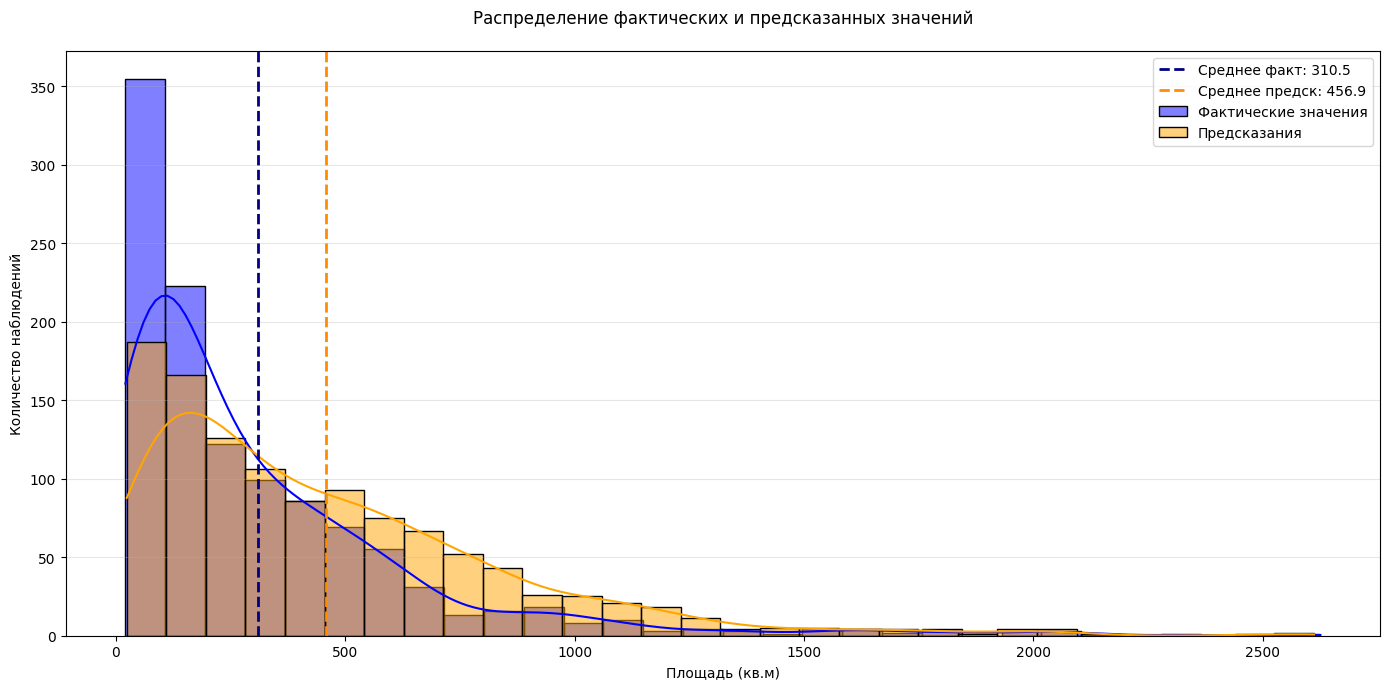

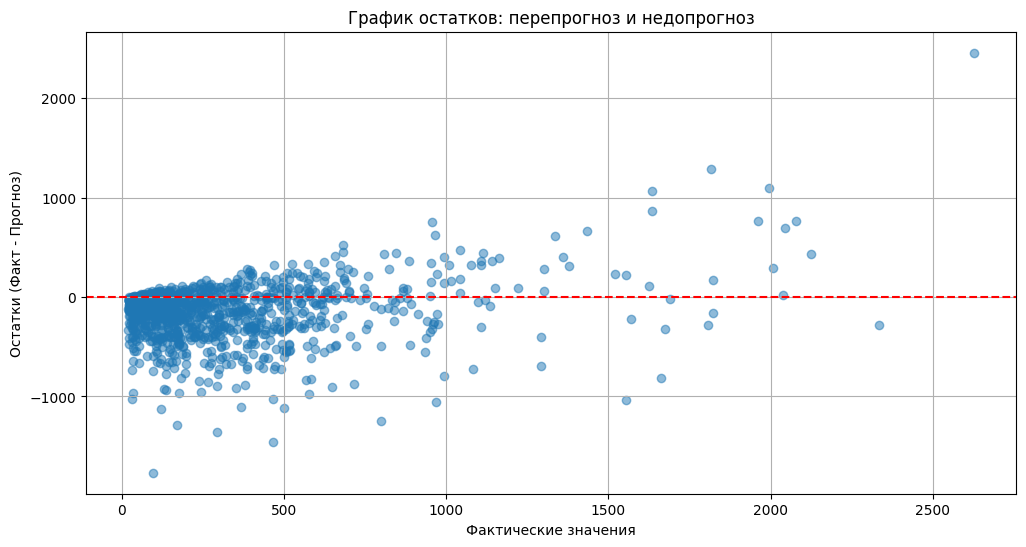

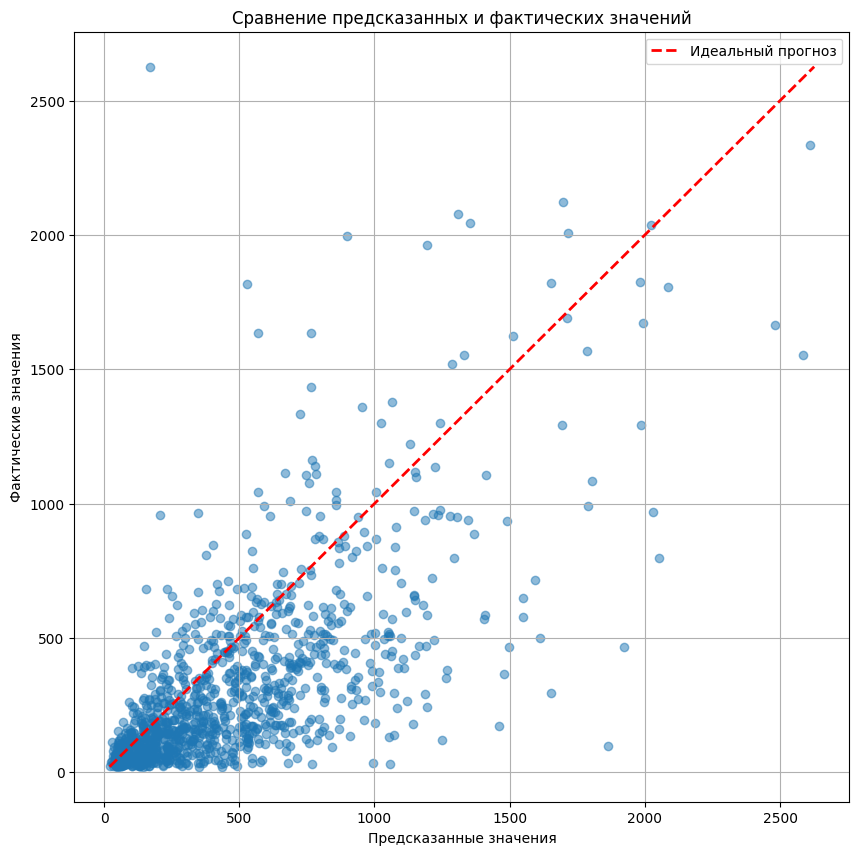

In [39]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()

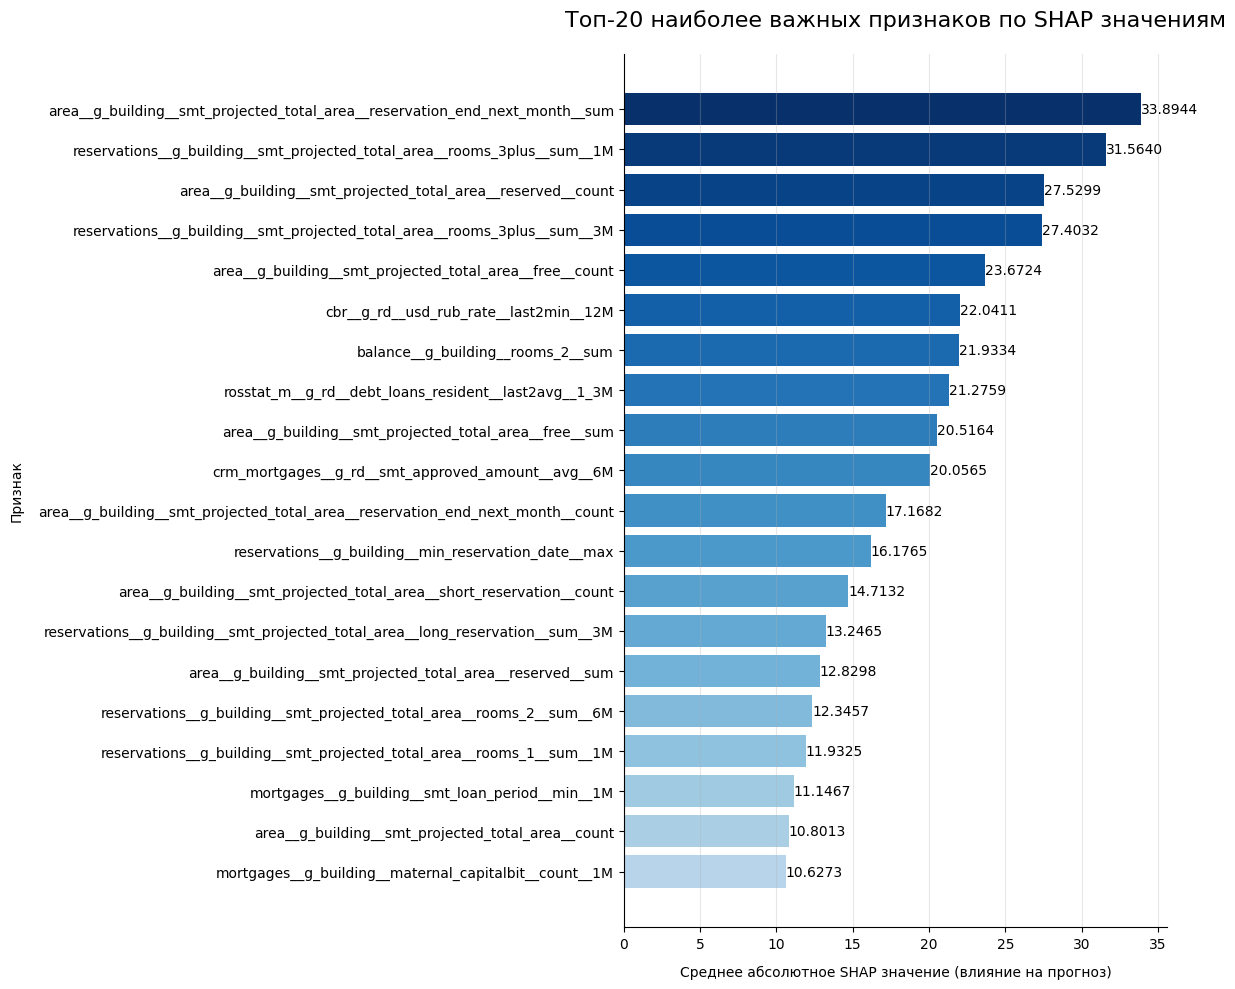

In [40]:
# Инициализация и расчет SHAP значений
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Создаем DataFrame с важностью фич
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values('importance', ascending=False).head(20)

# Стилизация графика
plt.figure(figsize=(12, 10))

# Горизонтальный bar plot с цветовой градацией
colors = plt.cm.Blues(np.linspace(0.3, 1, len(shap_importance)))
bars = plt.barh(shap_importance['feature'][::-1], 
                shap_importance['importance'][::-1],
                color=colors)

# Добавляем значения на график
for bar in bars:
    width = bar.get_width()
    plt.text(width, 
             bar.get_y() + bar.get_height()/2, 
             f'{width:.4f}', 
             ha='left', 
             va='center')

# Настройки внешнего вида
plt.title('Топ-20 наиболее важных признаков по SHAP значениям', pad=20, fontsize=16)
plt.xlabel('Среднее абсолютное SHAP значение (влияние на прогноз)', labelpad=10)
plt.ylabel('Признак', labelpad=10)
plt.grid(axis='x', alpha=0.3)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


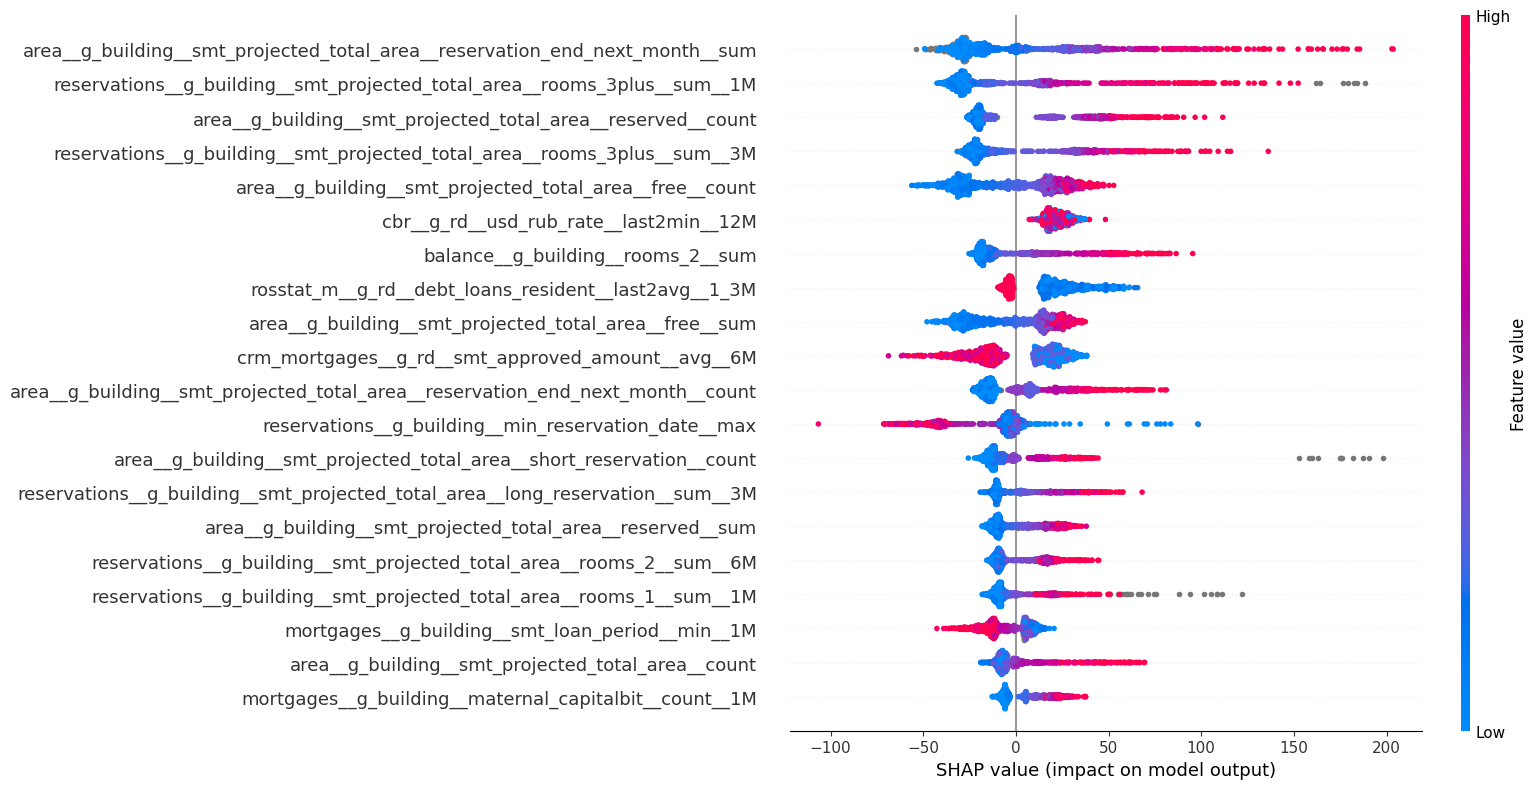

In [41]:
shap_gr(model, X_test)

# OPTUNA

In [42]:
# Разделяем данные
train_data = filtered_df[filtered_df['split_type'] == 'train']
test_data = filtered_df[filtered_df['split_type'] == 'oot']

X_train_full = train_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date',target_])
y_train_full = train_data[target_]

X_test = test_data.drop(columns=['split_type', 'smt_building_addressid', 'report_date', target_])
y_test = test_data[target_]

# Делим часть train на train/valid для Optuna
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, 
                                                    test_size=0.2, random_state=42)

# Для CatBoost нужно указывать cat_features
cat_features = ['year_month'] if 'year_month' in X_train.columns else []

# Улучшенная оптимизация через Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1000, 3000),
        "depth": trial.suggest_int("depth", 4, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 0.1, 3.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "loss_function": "MAE",
        "early_stopping_rounds": 100,
        "verbose": False,
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Lossguide", "Depthwise"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
    }

    # Добавляем параметры в зависимости от типа бутстрапа
    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0.0, 10.0)
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = trial.suggest_float("subsample", 0.5, 1.0)

    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), 
             cat_features=cat_features, early_stopping_rounds=100, verbose=0)
    
    preds = model.predict(X_valid)
    return mean_absolute_error(y_valid, preds)

# Улучшенный запуск Optuna
study = optuna.create_study(direction="minimize",
                          sampler=optuna.samplers.TPESampler(seed=42),
                          pruner=optuna.pruners.HyperbandPruner())

study.optimize(objective, n_trials=50)  

print("Лучшие параметры:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

# Обучаем финальную модель с лучшими параметрами
best_params = study.best_params.copy()
best_params.update({
    "loss_function": "MAE",
    "early_stopping_rounds": 100,
    "verbose": 100,
    "task_type": "CPU",  
})

# Удаляем параметры, которые не нужны в финальной модели
for param in ['iterations', 'early_stopping_rounds']:
    if param in best_params:
        del best_params[param]

final_model = CatBoostRegressor(**best_params)
final_model.fit(X_train_full, y_train_full,
               cat_features=cat_features,
               early_stopping_rounds=100,
               verbose=100)

# Делаем предсказания 
train_pred = final_model.predict(X_train_full)
test_pred = final_model.predict(X_test)

# Создаем DataFrame с метриками
metrics_df = pd.DataFrame([
    calculate_metrics(y_train_full, train_pred, 'train'),
    calculate_metrics(y_test, test_pred, 'test')
])

# Сохраняем результаты
metrics_df_optuna = metrics_df

[I 2025-05-19 22:55:52,644] A new study created in memory with name: no-name-f0020268-a85f-49f3-a768-3055948ed999
[I 2025-05-19 22:55:54,666] Trial 0 finished with value: 184.59740683443175 and parameters: {'iterations': 1749, 'depth': 8, 'learning_rate': 0.029106359131330698, 'l2_leaf_reg': 0.24810409748678114, 'random_strength': 0.5524540572830658, 'border_count': 66, 'min_data_in_leaf': 6, 'grow_policy': 'SymmetricTree', 'bootstrap_type': 'Bernoulli', 'subsample': 0.6061695553391381}. Best is trial 0 with value: 184.59740683443175.
[I 2025-05-19 22:55:56,445] Trial 1 finished with value: 199.71663839075018 and parameters: {'iterations': 1363, 'depth': 4, 'learning_rate': 0.004059611610484304, 'l2_leaf_reg': 0.12561043700013563, 'random_strength': 1.3526405540621358, 'border_count': 97, 'min_data_in_leaf': 62, 'grow_policy': 'Depthwise', 'bootstrap_type': 'Bernoulli', 'subsample': 0.7571172192068059}. Best is trial 0 with value: 184.59740683443175.
[I 2025-05-19 22:55:58,827] Trial 2

Лучшие параметры:
iterations: 1496
depth: 8
learning_rate: 0.02081151007962181
l2_leaf_reg: 0.0018242659401518247
random_strength: 0.5971529773015761
border_count: 108
min_data_in_leaf: 68
grow_policy: Depthwise
bootstrap_type: MVS
0:	learn: 357.9282626	total: 7.14ms	remaining: 7.13s
100:	learn: 187.7146105	total: 683ms	remaining: 6.08s
200:	learn: 156.3798274	total: 1.21s	remaining: 4.81s
300:	learn: 142.5220442	total: 1.66s	remaining: 3.85s
400:	learn: 133.2301601	total: 2.1s	remaining: 3.14s
500:	learn: 125.4228603	total: 2.51s	remaining: 2.5s
600:	learn: 118.8337167	total: 2.93s	remaining: 1.94s
700:	learn: 113.8365859	total: 3.35s	remaining: 1.43s
800:	learn: 110.0673854	total: 3.77s	remaining: 937ms
900:	learn: 106.4164699	total: 4.18s	remaining: 459ms
999:	learn: 103.7765733	total: 4.58s	remaining: 0us


In [43]:
metrics_df_optuna

,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,train,103.776575,37816.584634,194.464867,0.374882,0.198764,0.872746,522.109088,492.529426,5961
1,test,217.244740,102613.157797,320.332886,1.459467,0.699641,0.122561,310.508982,456.391760,1139


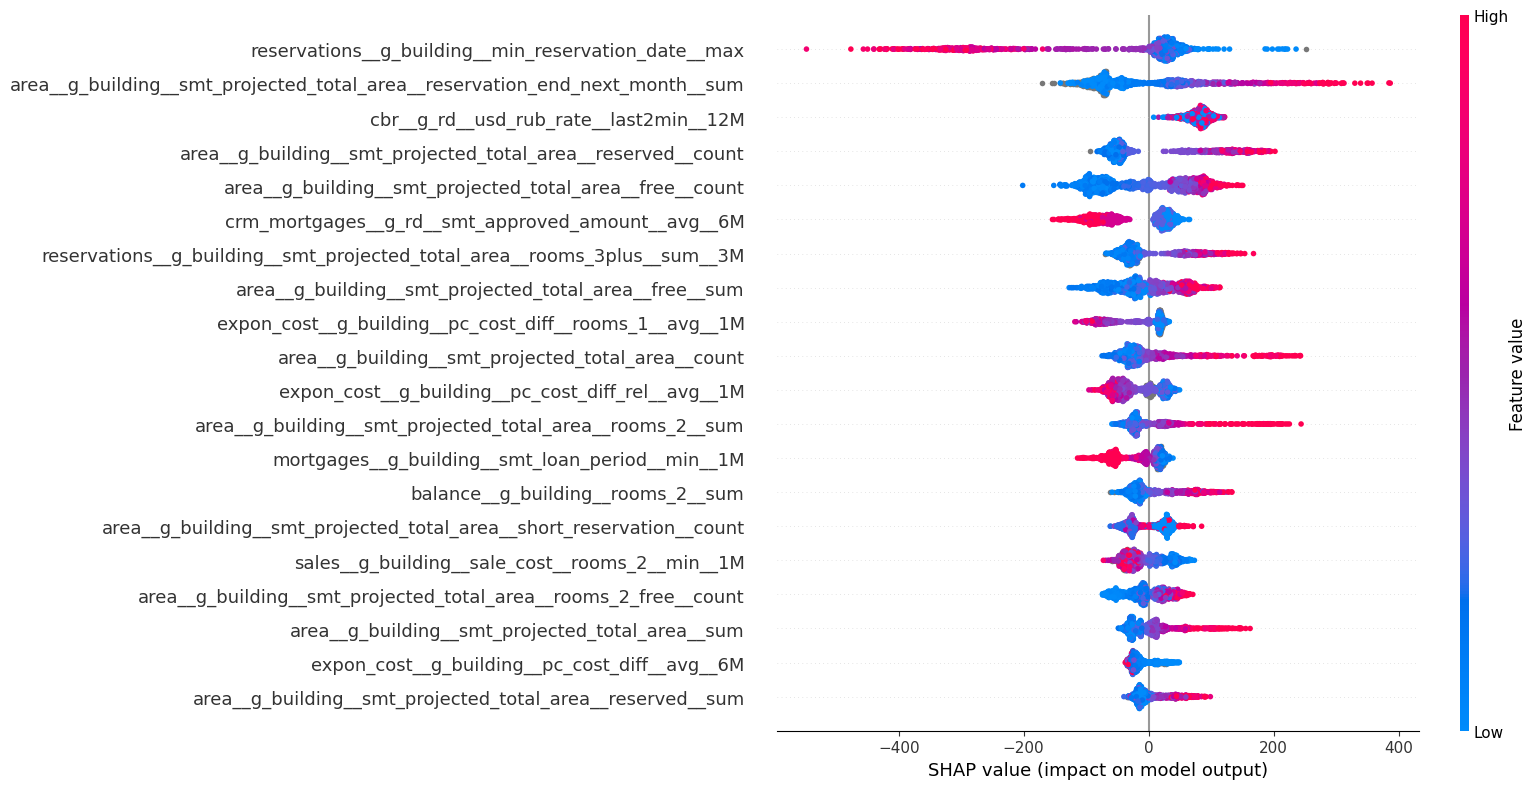

In [44]:
shap_gr(final_model, X_test)

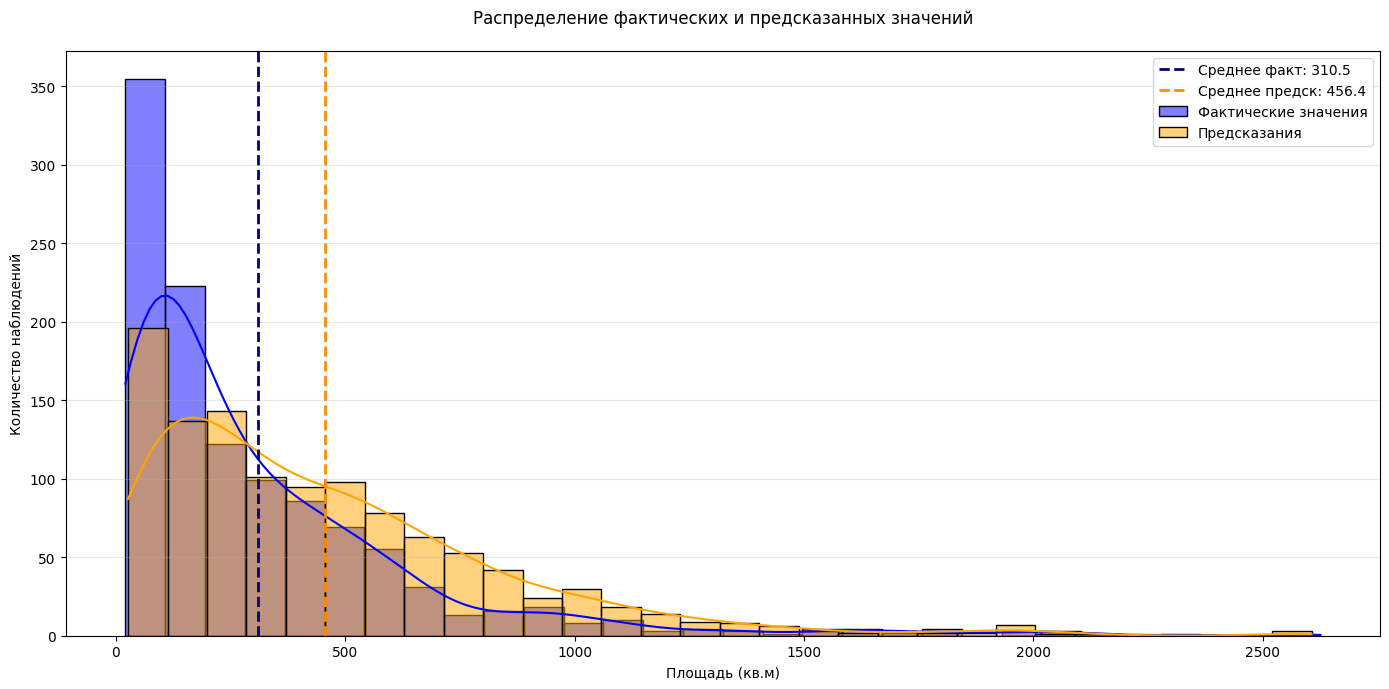

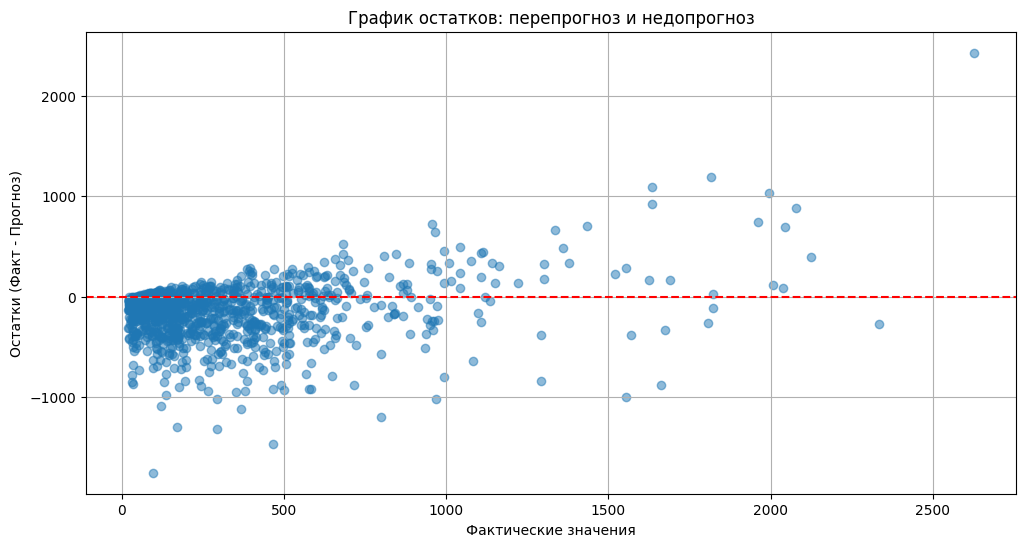

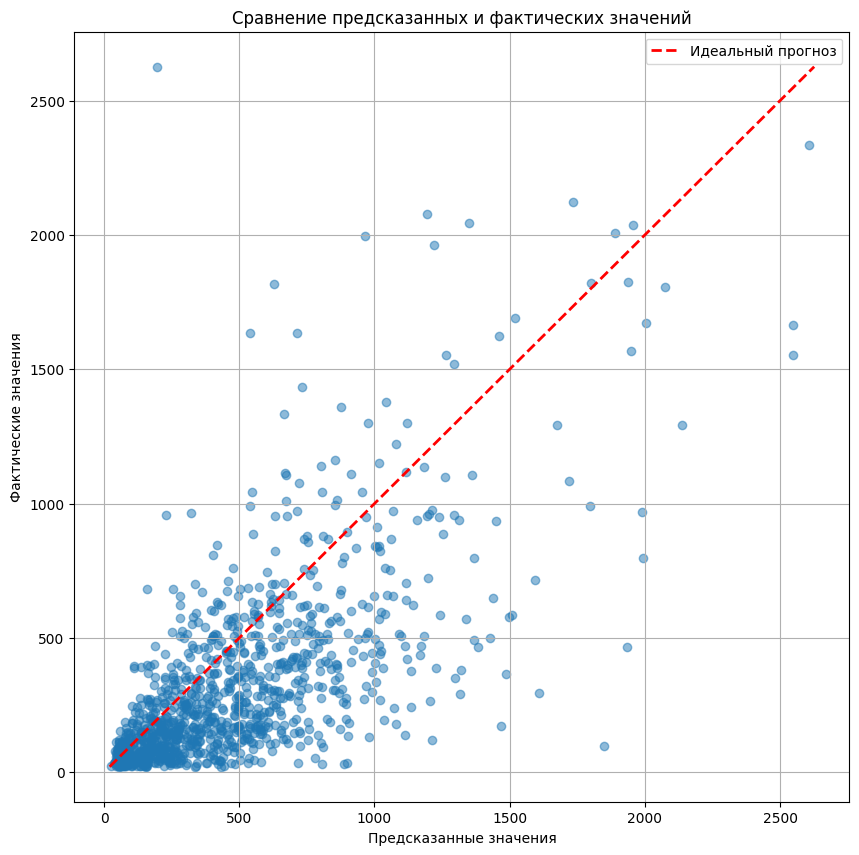

In [45]:
# 1. Анализ распределения таргета и предиктов
plt.figure(figsize=(14, 7))

# Гистограмма с наложением KDE
ax = sns.histplot(y_test, bins=30, color='blue', alpha=0.5, label='Фактические значения', kde=True)
sns.histplot(test_pred, bins=30, color='orange', alpha=0.5, label='Предсказания', kde=True, ax=ax)

# Добавляем линии средних
plt.axvline(y_test.mean(), color='navy', linestyle='--', linewidth=2, label=f'Среднее факт: {y_test.mean():.1f}')
plt.axvline(test_pred.mean(), color='darkorange', linestyle='--', linewidth=2, label=f'Среднее предск: {test_pred.mean():.1f}')

plt.title('Распределение фактических и предсказанных значений', pad=20)
plt.xlabel('Площадь (кв.м)')
plt.ylabel('Количество наблюдений')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 2. График перепрогноза/недопрогноза
residuals = y_test - test_pred
plt.figure(figsize=(12, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('График остатков: перепрогноз и недопрогноз')
plt.xlabel('Фактические значения')
plt.ylabel('Остатки (Факт - Прогноз)')
plt.grid()
plt.show()

# 3. Скэттерплот с диагональной линией
plt.figure(figsize=(10, 10))
plt.scatter(test_pred, y_test, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--', linewidth=2, label='Идеальный прогноз')
plt.title('Сравнение предсказанных и фактических значений')
plt.xlabel('Предсказанные значения')
plt.ylabel('Фактические значения')
plt.legend()
plt.grid()
plt.show()


In [ ]:
metrics_df_base.insert(0, 'stage', 'Базовая модель')
metrics_df_with_select_features.insert(0, 'stage', 'Модель с отбором признаков')
metrics_df_optuna.insert(0, 'stage', 'Оптимизированная модель (Optuna)')

In [58]:
result = pd.concat([metrics_df_base,metrics_df_with_select_features,metrics_df_optuna], ignore_index=True)
result

,stage,dataset,MAE,MSE,RMSE,MAPE,WAPE,R2,mean_target,mean_pred,n_samples
0,Базовая модель,train,92.859948,31818.687659,178.377935,0.314369,0.177855,0.892929,522.109088,497.796720,5961
1,Базовая модель,test,219.564145,108664.918830,329.643624,1.402345,0.707110,0.070813,310.508982,427.640153,1139
2,Модель с отбором признаков,train,141.229814,55212.208167,234.972782,0.508850,0.270499,0.814210,522.109088,487.013066,5961
3,Модель с отбором признаков,test,216.879267,104518.029987,323.292484,1.447808,0.698464,0.106273,310.508982,456.949554,1139
4,Оптимизированная модель (Optuna),train,103.776575,37816.584634,194.464867,0.374882,0.198764,0.872746,522.109088,492.529426,5961
5,Оптимизированная модель (Optuna),test,217.244740,102613.157797,320.332886,1.459467,0.699641,0.122561,310.508982,456.391760,1139


In [ ]:
# Сохраняем модель
with open('model_area.pkl', 'wb') as f:
    pickle.dump(final_model, f)
